In [87]:
# Library Imports 

import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from RAKE import rake
import seaborn as sns
import matplotlib.pyplot as plt
rake = rake.Rake("RAKE/SmartStoplist.txt")
from IPython.display import Markdown, display
import matplotlib.pyplot as plt


def printmd(string):
    display(Markdown(string))

% matplotlib inline

## Business Data

In [2]:
business = pd.read_json('./Data/business.json', lines =  True)
#business = pd.read_pickle('business.pkl')

print(business.shape)


# Only open businesses & with categories
business = business[business.is_open == 1]
business.drop(columns = ['address','is_open', 'latitude', 'longitude'], inplace = True)
business = business[business.categories.apply(len) != 0]

business.head()

(174567, 15)


,attributes,business_id,categories,city,hours,name,neighborhood,postal_code,review_count,stars,state
0,"{'AcceptsInsurance': True, 'ByAppointmentOnly'...",FYWN1wneV18bWNgQjJ2GNg,"[Dentists, General Dentistry, Health & Medical...",Ahwatukee,"{'Friday': '7:30-17:00', 'Tuesday': '7:30-17:0...",Dental by Design,,85044,22,4.0,AZ
1,"{'BusinessParking': {'garage': False, 'street'...",He-G7vWjzVUysIKrfNbPUQ,"[Hair Stylists, Hair Salons, Men's Hair Salons...",McMurray,"{'Monday': '9:00-20:00', 'Tuesday': '9:00-20:0...",Stephen Szabo Salon,,15317,11,3.0,PA
2,{},KQPW8lFf1y5BT2MxiSZ3QA,"[Departments of Motor Vehicles, Public Service...",Phoenix,{},Western Motor Vehicle,,85017,18,1.5,AZ
4,"{'Alcohol': 'full_bar', 'HasTV': True, 'NoiseL...",PfOCPjBrlQAnz__NXj9h_w,"[American (New), Nightlife, Bars, Sandwiches, ...",Cuyahoga Falls,"{'Monday': '11:00-1:00', 'Tuesday': '11:00-1:0...",Brick House Tavern + Tap,,44221,116,3.5,OH
5,"{'GoodForMeal': {'dessert': False, 'latenight'...",o9eMRCWt5PkpLDE0gOPtcQ,"[Italian, Restaurants]",Stuttgart,"{'Monday': '18:00-0:00', 'Tuesday': '18:00-0:0...",Messina,,70567,5,4.0,BW


In [3]:
print('Size : ',business.shape)
display(business.info())

Size :  (146226, 11)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 146226 entries, 0 to 174566
Data columns (total 11 columns):
attributes      146226 non-null object
business_id     146226 non-null object
categories      146226 non-null object
city            146226 non-null object
hours           146226 non-null object
name            146226 non-null object
neighborhood    146226 non-null object
postal_code     146226 non-null object
review_count    146226 non-null int64
stars           146226 non-null float64
state           146226 non-null object
dtypes: float64(1), int64(1), object(9)
memory usage: 13.4+ MB


None

## Review Data

In [4]:
# Takes a lot of time to read
review = pd.DataFrame()

df = pd.read_json('./Data/review.json',lines = True, chunksize= 1e5)

try:
   for df_chunk in df:
       review = pd.concat([review, df_chunk])
except ValueError:
       print ('\nSome messages in the file cannot be parsed')

review.drop(columns = ['cool','funny'], inplace = True)

print(review.shape)

review.head()

(5261669, 7)


,business_id,date,review_id,stars,text,useful,user_id
0,0W4lkclzZThpx3V65bVgig,2016-05-28,v0i_UHJMo_hPBq9bxWvW4w,5,"Love the staff, love the meat, love the place....",0,bv2nCi5Qv5vroFiqKGopiw
1,AEx2SYEUJmTxVVB18LlCwA,2016-05-28,vkVSCC7xljjrAI4UGfnKEQ,5,Super simple place but amazing nonetheless. It...,0,bv2nCi5Qv5vroFiqKGopiw
2,VR6GpWIda3SfvPC-lg9H3w,2016-05-28,n6QzIUObkYshz4dz2QRJTw,5,Small unassuming place that changes their menu...,0,bv2nCi5Qv5vroFiqKGopiw
3,CKC0-MOWMqoeWf6s-szl8g,2016-05-28,MV3CcKScW05u5LVfF6ok0g,5,Lester's is located in a beautiful neighborhoo...,0,bv2nCi5Qv5vroFiqKGopiw
4,ACFtxLv8pGrrxMm6EgjreA,2016-05-28,IXvOzsEMYtiJI0CARmj77Q,4,Love coming here. Yes the place always needs t...,0,bv2nCi5Qv5vroFiqKGopiw


In [8]:
review.columns = ['business_id', 'date', 'review_id', 'review_stars', 'text', 'useful','user_id']
review['review_length'] = review.text.apply(len)
review.columns

Index(['business_id', 'date', 'review_id', 'review_stars', 'text', 'useful',
       'user_id', 'review_length'],
      dtype='object')

In [9]:
review.describe()

,review_stars,useful,review_length
count,5.261669e+06,5.261669e+06,5.261669e+06
mean,3.727740e+00,1.385085e+00,6.116914e+02
std,1.433593e+00,4.528727e+00,5.719504e+02
min,1.000000e+00,-1.000000e+00,1.000000e+00
25%,3.000000e+00,0.000000e+00,2.420000e+02
50%,4.000000e+00,0.000000e+00,4.340000e+02
75%,5.000000e+00,2.000000e+00,7.800000e+02
max,5.000000e+00,3.364000e+03,5.000000e+03


In [10]:
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5261669 entries, 0 to 5261668
Data columns (total 8 columns):
business_id      object
date             datetime64[ns]
review_id        object
review_stars     int64
text             object
useful           int64
user_id          object
review_length    int64
dtypes: datetime64[ns](1), int64(3), object(4)
memory usage: 321.1+ MB


## Check-In Data

In [6]:
checkin = pd.read_json('./Data/checkin.json', lines = True)
#checkin = pd.read_pickle('checkin.pkl')
print(checkin.shape)
checkin.head()

(146350, 2)


,business_id,time
0,7KPBkxAOEtb3QeIL9PEErg,"{'Thursday': {'21:00': 4, '1:00': 1, '4:00': 1..."
1,kREVIrSBbtqBhIYkTccQUg,"{'Monday': {'13:00': 1}, 'Thursday': {'20:00':..."
2,tJRDll5yqpZwehenzE2cSg,"{'Monday': {'12:00': 1, '1:00': 1}, 'Friday': ..."
3,r1p7RAMzCV_6NPF0dNoR3g,"{'Thursday': {'23:00': 1}, 'Saturday': {'21:00..."
4,mDdqgfrvROGAumcQdZ3HIg,"{'Monday': {'12:00': 1, '21:00': 1}, 'Wednesda..."


## User Data

In [21]:
user = pd.read_json('./Data/user.json', lines = True)
#user = pd.read_pickle('user.pkl')

user_columns_to_remove = ['compliment_cool', 'compliment_cute',
       'compliment_funny', 'compliment_hot', 'compliment_list',
       'compliment_more', 'compliment_note', 'compliment_photos',
       'compliment_plain', 'compliment_profile', 'compliment_writer',
       'cool','fans', 'friends', 'funny',
       'useful', 'yelping_since']
user.drop(columns = user_columns_to_remove, inplace = True)

user.elite = user.elite.apply(lambda x: 0 if len(x) == 0 else 1)
elite_user_id = user[user.elite == 1].user_id.values
print(user.shape)
user.head()

(1326101, 5)


,average_stars,elite,name,review_count,user_id
0,4.67,0,Johnny,8,oMy_rEb0UBEmMlu-zcxnoQ
1,3.70,0,Chris,10,JJ-aSuM4pCFPdkfoZ34q0Q
2,2.00,0,Tiffy,1,uUzsFQn_6cXDh6rPNGbIFA
3,4.67,0,Mark,6,mBneaEEH5EMyxaVyqS-72A
4,4.67,0,Evelyn,3,W5mJGs-dcDWRGEhAzUYtoA


In [13]:
user.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1326101 entries, 0 to 1326100
Data columns (total 5 columns):
average_stars    1326101 non-null float64
elite            1326101 non-null object
name             1326101 non-null object
review_count     1326101 non-null int64
user_id          1326101 non-null object
dtypes: float64(1), int64(1), object(3)
memory usage: 60.7+ MB


## Using only half the data

In [14]:
# # train_test_split
# business, _ = train_test_split(business, test_size = 0.5)
# review, _ = train_test_split(review, test_size = 0.5)
# user, _ = train_test_split(user, test_size = 0.5)

# Exploratory Data Analysis

## Distribution of Reviews

In [27]:
dist_reviews = review.user_id.value_counts().value_counts()

Text(0.5,0,'Number of reviews')

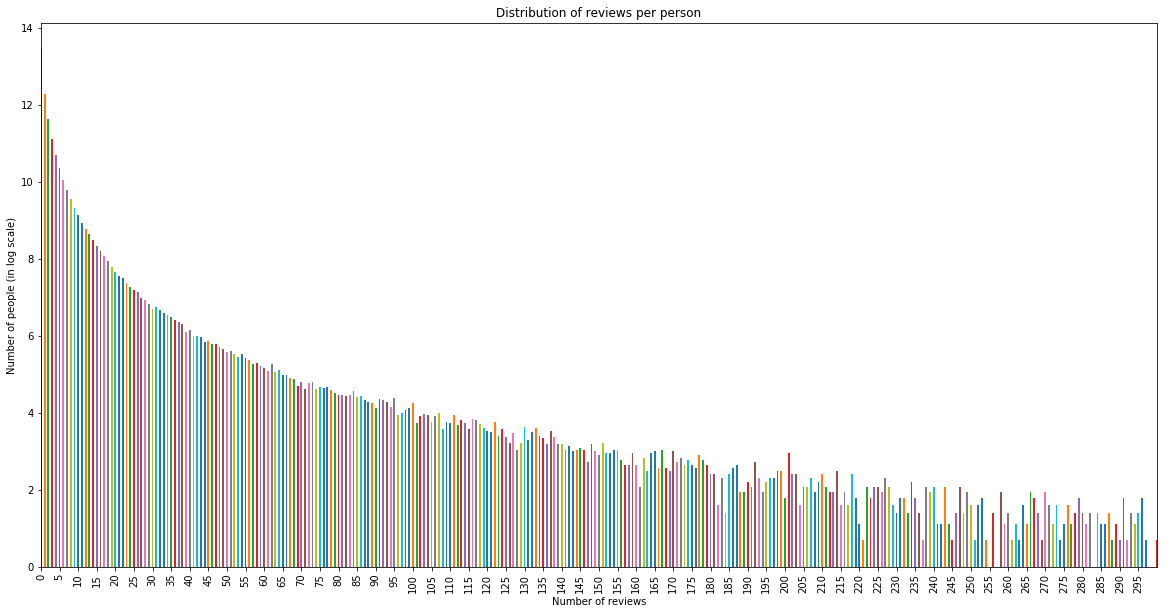

In [46]:
ax = np.log(dist_reviews).sort_index().plot(kind = 'bar', title = 'Distribution of reviews per person', figsize = (20,10))


ax.set_xlim(0, 300)
ax.set_xticklabels(np.arange(0, 300, 5))
ax.xaxis.set_ticks(np.arange(0, 300, 5))
ax.set_ylabel("Number of people (in log scale)")
ax.set_xlabel("Number of reviews")

Text(0.5,0,'Number of reviews')

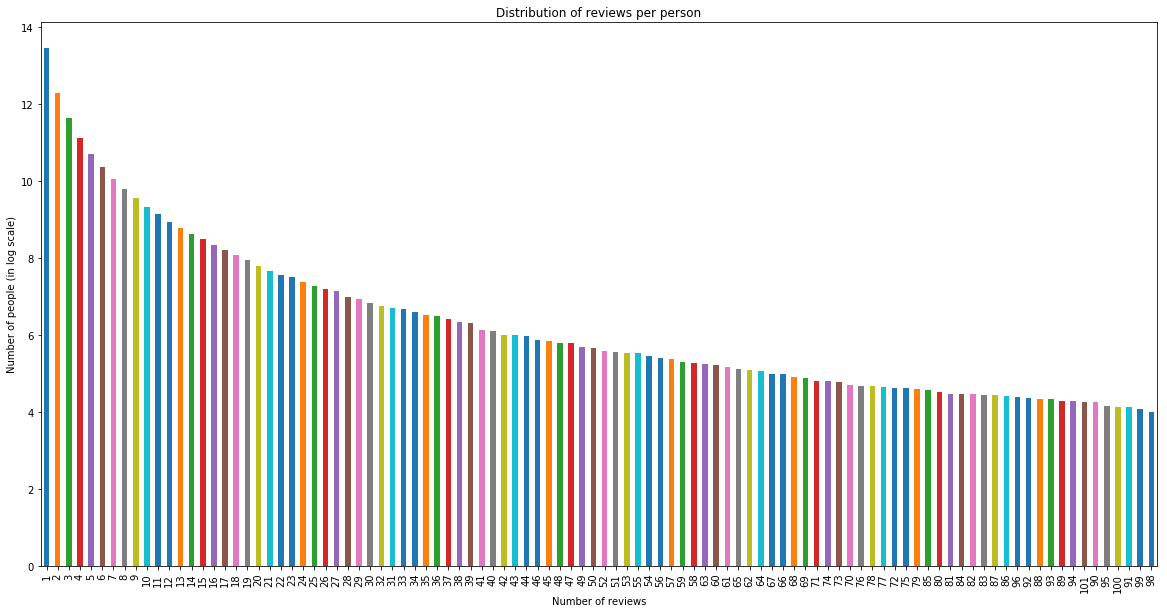

In [47]:
ax = np.log(dist_reviews[ :100]).plot(kind = 'bar', title = 'Distribution of reviews per person', figsize = (20,10))
ax.set_ylabel("Number of people (in log scale)")
ax.set_xlabel("Number of reviews")

## Person with the most reviews

In [48]:
max_rev_user_id = user.user_id[user.review_count == max(user.review_count)].values[0]
print('Name : %s' % (user.name[user.user_id == max_rev_user_id].values[0]))
print('Number of Reviews : %s' % (user.review_count[user.user_id == max_rev_user_id].values[0]))

person_most_reviews = review[review.user_id == max_rev_user_id]
print('First Review : %s' % min(person_most_reviews.date))
print('Latest Review : %s' % max(person_most_reviews.date))

Name : Victor
Number of Reviews : 11954
First Review : 2008-03-01 00:00:00
Latest Review : 2014-05-24 00:00:00


In [49]:
person_most_reviews

,business_id,date,review_id,review_stars,text,useful,user_id,review_length
5214593,6Q7-wkCPc1KF75jZLOTcMw,2011-03-25,Cg544WBUSYsJZRP_zjUYYw,1,"Decades ago, i booked low priced rooms here ...",2,8k3aO-mPeyhbR5HUucA5aA,771
5214594,J-U6C8FgveGsDdHwRB56OQ,2014-05-24,UnW63C7p_5FEAqcN9vUGgQ,1,"on or about june 25th, 2013, Global Pharmacy C...",51,8k3aO-mPeyhbR5HUucA5aA,651
5214595,ii8sAGBexBOJoYRFafF9XQ,2008-03-01,Hrlm9LvgiQTvmw0L5zOqOQ,3,i stayed here but don't remember much else. th...,0,8k3aO-mPeyhbR5HUucA5aA,344
5214596,DfgZlNgKwBvCpA_0alumXw,2008-03-01,7M8WX2FErASIRdf68r_NIQ,3,sure they give you free cohibas and cognac for...,1,8k3aO-mPeyhbR5HUucA5aA,285
5214597,z7GAft_JrFNmAH5xbVeYSA,2008-03-01,lobDkv7bYpJXuG_ZBKPOUg,3,it was pretty cheap to fly to las vegas. depen...,3,8k3aO-mPeyhbR5HUucA5aA,206
5214598,na4Th5DrNauOv-c43QQFvA,2008-03-01,idtF1AP1tlTHMVJVmX4NzQ,3,"when i was there, this place spelled elegance ...",1,8k3aO-mPeyhbR5HUucA5aA,96
5214599,u_vPjx925UPEG9DFOAAvFQ,2008-03-01,hsKnV3BM6se0VcnFM7RIMw,2,was this one of many casinos that didn't offer...,1,8k3aO-mPeyhbR5HUucA5aA,118


## Ratings

Text(0.5,0,'Rating of review')

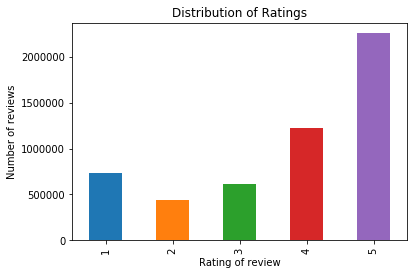

In [52]:
ax = review['review_stars'].value_counts().sort_index().plot(kind = 'bar', title = 'Distribution of Ratings')
ax.set_ylabel("Number of reviews")
ax.set_xlabel("Rating of review")

Text(0.5,0,'Average review rating')

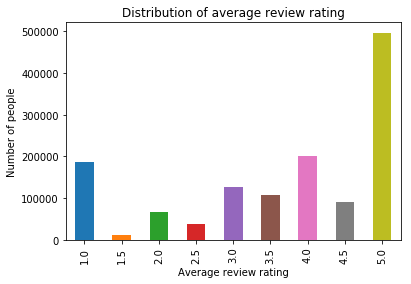

In [88]:
avg_rating_user = pd.Series(np.round(review[['review_stars', 'user_id']].groupby('user_id').mean()['review_stars'].values * 2) / 2)
ax = avg_rating_user.value_counts().sort_index().plot(kind = 'bar', title = 'Distribution of average review rating')

ax.set_ylabel("Number of people")
ax.set_xlabel("Average review rating")

In [89]:
avg_rating_user_elite = pd.Series(np.round(review[review.user_id.isin(elite_user_id)][['review_stars', 'user_id']].groupby('user_id').mean()['review_stars'].values * 2) / 2)
avg_rating_user_non_elite = pd.Series(np.round(review[~review.user_id.isin(elite_user_id)][['review_stars', 'user_id']].groupby('user_id').mean()['review_stars'].values * 2) / 2)

**Distribution of average review rating**

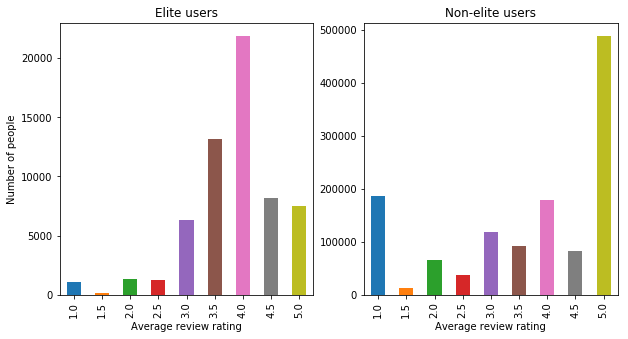

In [91]:
printmd('**Distribution of average review rating**')
plt.subplots(1, 2, figsize=(10, 5))
plt.subplot(1, 2, 1)
ax = avg_rating_user_elite.value_counts().sort_index().plot(kind = 'bar', title = 'Elite users')
ax.set_ylabel("Number of people")
ax.set_xlabel("Average review rating")
plt.subplot(1, 2, 2)
ax1 = avg_rating_user_non_elite.value_counts().sort_index().plot(kind = 'bar', title = 'Non-elite users')
ax1.set_xlabel("Average review rating")
print()

## Most Common Business Categories

Text(0.5,0,'Business categories')

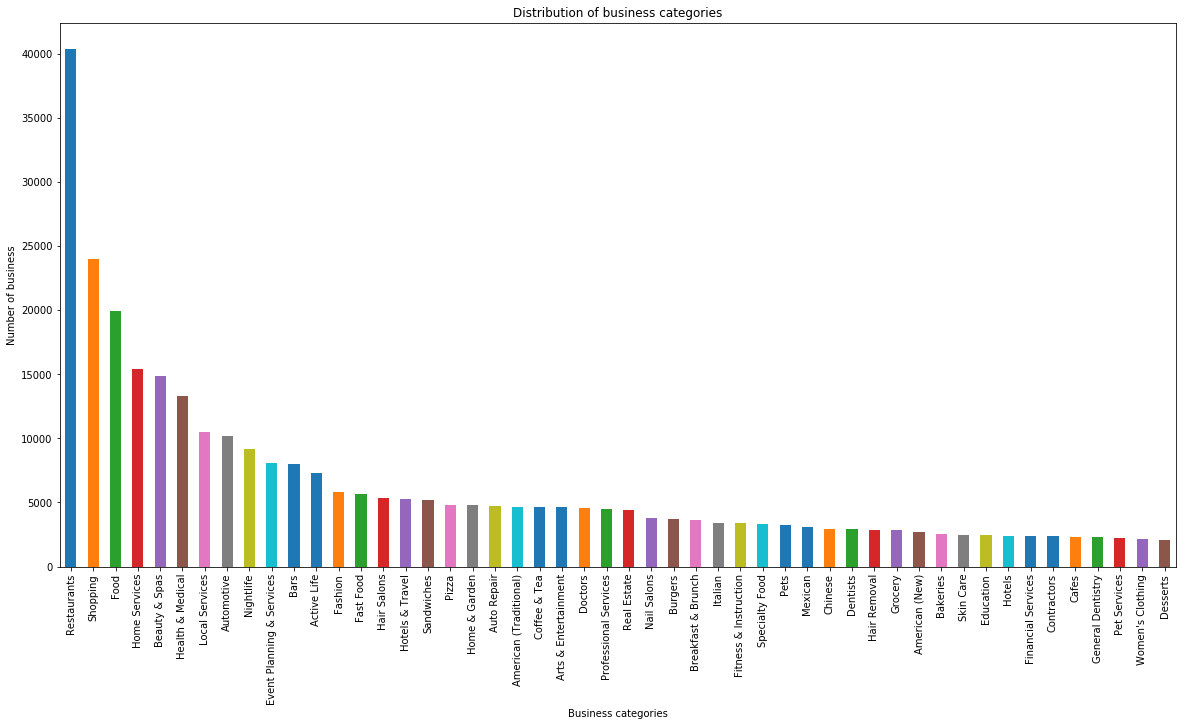

In [93]:
all_business_categories = [item for sublist in business.categories for item in sublist]
ax = pd.Series(all_business_categories).value_counts()[:50].plot(kind = 'bar', figsize = (20,10), title = 'Distribution of business categories')
ax.set_ylabel("Number of business")
ax.set_xlabel("Business categories")

## Most Reviewed Business Categories

Text(0.5,0,'Business categories')

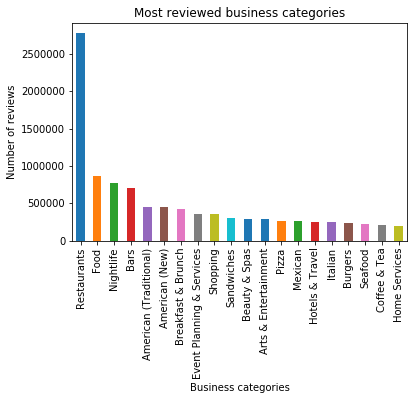

In [94]:
x = pd.get_dummies(business.categories.apply(pd.Series).stack()).sum(level = 0)
most_reviewed_places = x.apply(lambda x: np.asarray(x) * np.asarray(business.review_count[business.categories.apply(len) != 0]))
ax = most_reviewed_places.sum().sort_values(ascending = False)[:20].plot(kind = 'bar', title = 'Most reviewed business categories')
ax.set_ylabel("Number of reviews")
ax.set_xlabel("Business categories")

Text(0.5,0,'Business categories')

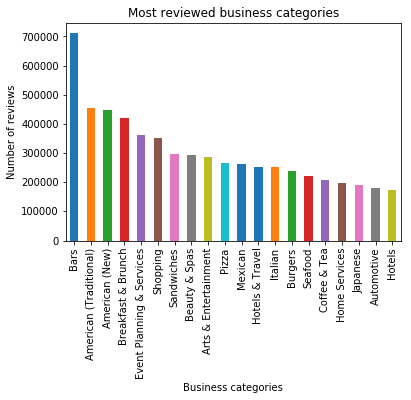

In [95]:
most_reviewed_places = x.drop(columns = ['Restaurants', 'Food', 'Nightlife']).apply(lambda x: np.asarray(x) * np.asarray(business.review_count[business.categories.apply(len) != 0]))
ax = most_reviewed_places.sum().sort_values(ascending = False)[:20].plot(kind = 'bar', title = 'Most reviewed business categories')
ax.set_ylabel("Number of reviews")
ax.set_xlabel("Business categories")

Text(0.5,0,'Business categories')

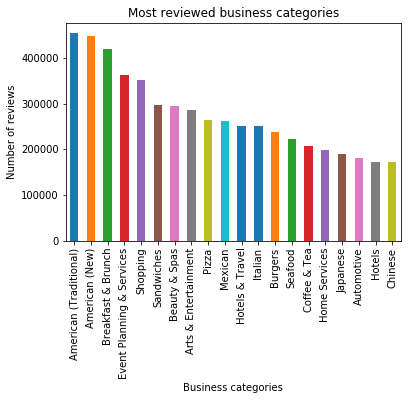

In [96]:
most_reviewed_places = x.drop(columns = ['Restaurants', 'Food', 'Nightlife', 'Bars']).apply(lambda x: np.asarray(x) * np.asarray(business.review_count[business.categories.apply(len) != 0]))
ax = most_reviewed_places.sum().sort_values(ascending = False)[:20].plot(kind = 'bar', title = 'Most reviewed business categories')
ax.set_ylabel("Number of reviews")
ax.set_xlabel("Business categories")

## Review Text Length

In [ ]:
review[review.user_id.isin(elite_user_id)].review_length.mean(), review[~review.user_id.isin(elite_user_id)].review_length.mean()


**Across all users**

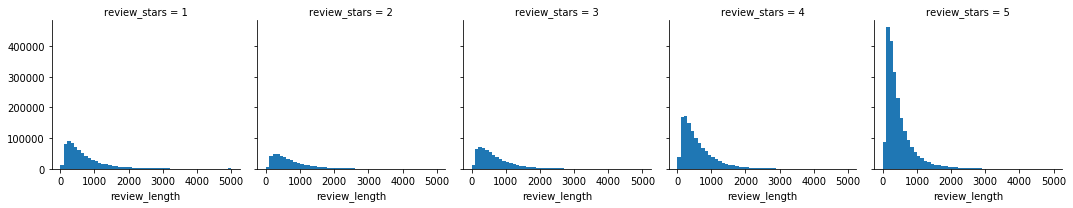

In [99]:
printmd('**Across all users**')
textSizeGraph = sns.FacetGrid(data = review, col = 'review_stars')
textSizeGraph.map(plt.hist, 'review_length', bins = 50)

**Elite users**

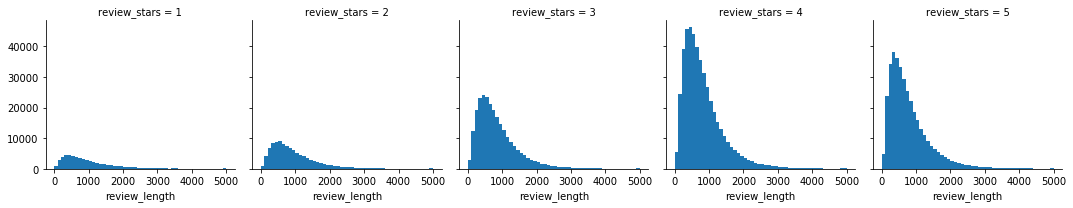

In [102]:
printmd('**Elite users**')
textSizeGraph_elite = sns.FacetGrid(data = review[review.user_id.isin(elite_user_id)], col = 'review_stars')
textSizeGraph_elite.map(plt.hist, 'review_length', bins = 50)

**Non-elite users**

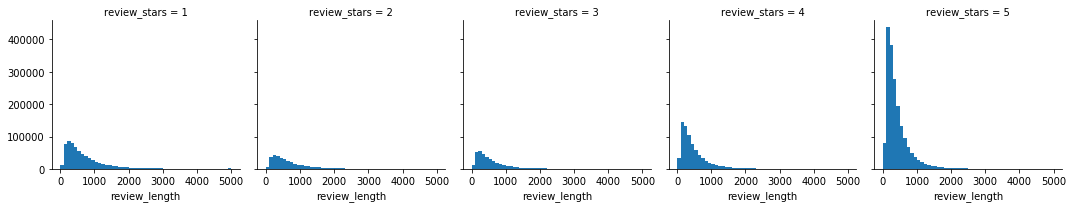

In [101]:
printmd('**Non-elite users**')
textSizeGraph_non_elite = sns.FacetGrid(data = review[~review.user_id.isin(elite_user_id)], col = 'review_stars')
textSizeGraph_non_elite.map(plt.hist, 'review_length', bins = 50)

In [ ]:
## Correlation between text length and rating
sns.heatmap(review.mean().corr(), annot = True)

## Dropping Records that are not part of the analysis

In [ ]:
# Dropping non restaurants businesses
bus_cat_filter = business.categories.apply(lambda x: False if 'Restaurants' in x else True)
business.drop(business[bus_cat_filter].index, inplace = True)

In [ ]:
# Dropping reviews of non restaurants and non-food business
rew_busniess_filter = review.business_id.isin(list(business.business_id))
review = review[rew_busniess_filter]

In [ ]:
y = pd.get_dummies(business.categories.apply(pd.Series).stack()).sum(level = 0)
y = y.replace(0, np.NaN)
ydf = pd.DataFrame(y.multiply(business['stars'], axis = 0).mean())
y_fil_index = y.multiply(business['stars'], axis = 0).count()[y.multiply(business['stars'], axis = 0).count() > 5].index

In [ ]:
# business[business.categories.apply(lambda x: True if 'Personal Assistants' in x else False)]['categories'].values

In [ ]:
y_fil_index = y.multiply(business['stars'], axis = 0).count()[y.multiply(business['stars'], axis = 0).count() > 50].index
ax = ydf.loc[y_fil_index, 0].sort_values(ascending = False)[ :50].plot(kind = 'bar', figsize = (20,10), title = 'Top rated business categories')
ax.set_ylim(3.65, 4.25)
ax.set_ylabel("Average review rating")
ax.set_xlabel("Food categories")

# FEATURE ENGINEERING

## 1. Avg restaurant rating

In [ ]:
# Avg restaurant rating
avg_restaurant_rating = review.groupby('business_id').mean()[['stars']]
avg_restaurant_rating.columns = ['avg_rating']
business = pd.merge(business, avg_restaurant_rating, how='inner', on=None, 
                     left_on='business_id', right_on=None,
                     left_index=False, right_index=True, sort=True,
                     suffixes=('_x', '_y'), copy=True, indicator=False,
                     validate=None)

In [ ]:
# print(business.columns, business.shape)
# print(review.columns, review.shape)

## 2. One Hot Type Encoding of Business Categories

In [ ]:
business_categories_df = pd.get_dummies(business.categories.apply(pd.Series).stack()).sum(level=0)
business_categories_counts = business_categories_df.sum().sort_values(ascending = False)

business_categories_drop = list(business_categories_counts[business_categories_counts < 10].index.values)
business_categories_drop.append('Restaurants')
business_categories_drop.append('Food')
business_categories_df.drop(columns = business_categories_drop, inplace = True)

business.drop(columns = ['categories'], inplace = True)
business = pd.concat([business, business_categories_df], axis=1)

business = business[business[business_categories_df.columns].sum(axis = 1) != 0]
print(business.columns, business.shape)

In [ ]:
ax = business_categories_df.sum().sort_values(ascending = False)[:20].plot(kind = 'bar', title = 'Most common restaurant categories')
ax.set_ylabel("Number of restaurants")
ax.set_xlabel("Food categories")

In [ ]:
alldf = pd.merge(business, review, how='inner', on=None, 
                     left_on='business_id', right_on='business_id',
                     left_index=False, right_index=False, sort=True,
                     suffixes=('_business', '_review'), copy=True, indicator=False,
                     validate=None)
alldf = pd.merge(alldf, user, how='inner', on=None, 
                     left_on='user_id', right_on='user_id',
                     left_index=False, right_index=False, sort=True,
                     suffixes=('', '_user'), copy=True, indicator=False,
                     validate=None)

In [ ]:
user_idx = '4hEEqc04QumsW4HsWSUMxg'
 
def userCategoriesRatings(user_id, cols = business_categories_df.columns):
    person_filter = alldf.user_id == user_id
    df = alldf[person_filter]
    df = df.replace(0, np.NaN)

    #top_cat = df[cols].apply(lambda x: np.asarray(x) * np.asarray(df.review_stars.values)).mean()
    top_cat = df[cols].multiply(df.review_stars, axis = 0).mean()

    return top_cat[~(top_cat.isnull())]
    
userCategoriesRatings(user_idx)

In [ ]:


def get_business_keywords(business_id):
    df = review.loc[(review['business_id'] == business_id) & (review['review_stars'] == 5)]
    keywords_list = []
    for idx, r in df.iterrows():
        keywords_list.extend(rake.run(r.text))
    sorted_keywords = sorted(keywords_list, key=lambda tup: tup[1], reverse=True)
    
    return sorted_keywords

def extract_keywords(keyword, n = 10):
    res = []
    for i in keyword:
        if len(res) == n:
            break
        res.append(i[0])
    return res


In [ ]:
def userVisited(user_id, inverse = 0):
    if inverse == 0:
        res = review.business_id[review.user_id == user_id].unique()
    else:
        res = review.business_id[~(review.user_id == user_id)].unique()
    return res

# Most Popular Recommendations

In [ ]:
def mostPopular(user_id, city, limit = 10):
    top_picks = business[business.city == city]
    
    print('Total available options in the location : %d' % (top_picks.shape[0]))
    
    places_visited = review.business_id[review.user_id == user_id]
    
    top_picks = top_picks[~top_picks.business_id.isin(places_visited)]
    top_picks = top_picks.sort_values('avg_rating', ascending = False)
    
    return top_picks['name'][:limit].values

In [ ]:
mostPopular('JJ-aSuM4pCFPdkfoZ34q0Q', 'Toronto')

In [ ]:
list_col = list(business_categories_df.columns.values)
user_cat_matrix = alldf.loc[:, list_col].multiply(alldf.review_stars, axis = 0).replace(0, np.NaN)
user_cat_matrix['user_id'] = alldf.user_id
user_cat_matrix = user_cat_matrix.groupby('user_id').mean()



In [ ]:
user_cat_matrix.head()

# Baseline Prediction

http://cs229.stanford.edu/proj2013/SawantPai-YelpFoodRecommendationSystem.pdf

In [ ]:
mu = np.mean(review.review_stars)
mean_user_ratings = review[['user_id', 'review_stars']].groupby('user_id').mean()
mean_business_ratings = review[['business_id', 'review_stars']].groupby('business_id').mean()


In [ ]:
def baseline_rating(user_id, business_id, mu = mu):
    bu = mean_user_ratings.loc[user_id, 'review_stars']
    bf = mean_business_ratings.loc[business_id, 'review_stars'] 
    
    bu -= mu
    bf -= mu
    
    return mu + bf + bu

baseline_rating(user_idx,'--I7YYLada0tSLkORTHb5Q')

# User-User Collaborative filtering:

In [ ]:
# User-User Collaborative filtering:

def findSimilarRestaurants(user_id, user_cat_matrix = user_cat_matrix, n = 10):
    
    person = np.array(user_cat_matrix.loc[user_id,])[:, np.newaxis]
    others = np.array(user_cat_matrix[user_cat_matrix.index != user_idx])
    scores = np.sum((others * person.T), axis = 1)/ (np.sum(person*2) * np.sum(others*2, axis = 1))
    
    sim_user_id = user_cat_matrix.index.values[np.argsort(-scores)[:n]]
    
    sim_visited = []
    for i in sim_user_id:
        sim_visited.extend(userVisited(i))
        
    sim_visited = pd.DataFrame(pd.Series(sim_visited).value_counts(), columns = ['Counts'])
    bus_col = ['stars', 'business_id', 'name']
    bus_col.extend(userCategoriesRatings(user_idx).index.values)
    
    suggestions = pd.merge(sim_visited, business[bus_col], how='inner', on=None, 
                     left_on=None, right_on='business_id',
                     left_index=True, right_index=False, sort=True,
                     suffixes=('_business', '_review'), copy=True, indicator=False,
                     validate=None)
    
    suggestions = suggestions[~suggestions.business_id.isin(userVisited(user_idx))]
    suggestions['user_fav_cuisine'] = suggestions[userCategoriesRatings(user_idx).index.values].sum(axis = 1)
    suggestions["keywords"] = suggestions.business_id.apply(get_business_keywords)
    suggestions['top_picks'] = suggestions['keywords'].apply(extract_keywords)
    suggestions['baseline_rating'] = suggestions.apply(lambda row: baseline_rating(user_id, row['business_id']), axis=1)
    
    return suggestions.sort_values(by = ['Counts','stars', 'user_fav_cuisine'], ascending = False)
    
reco = findSimilarRestaurants(user_idx, user_cat_matrix)

In [ ]:
reco

In [ ]:
from sklearn.model_selection import train_test_split

filtter = ['attributes', 'hours', 'review_count_user', 'neighborhood', 'name_user', 'review_id', 'review_stars', 'business_id', 'text', 'useful', 'city', 'name', 'postal_code', 'state', 'user_id', 'date']

train_data, test_data, train_label, test_label = train_test_split(alldf.drop(columns = filtter), alldf['review_stars'])



In [ ]:
train_data.dtypes

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logreg = LogisticRegression()
logreg.fit(train_data, train_label)

In [ ]:
accuracy_score(test_label, logreg.predict(test_data))

In [ ]:
accuracy_score(test_label, clf.predict(test_data))

In [ ]:
def prrrd(user_id, df = alldf):

    df = df[df.user_id == user_id]
    
    if (df.review_stars).nunique() == 1:
        return 1.0
    
    filters = ['attributes', 'hours', 'review_count_user', 'neighborhood', 'name_user', 'review_id', 'business_id', 'text', 'useful', 'city', 'name', 'postal_code', 'state', 'user_id', 'date']
    df.drop(columns = filters, inplace = True)

    train_data, test_data, train_label, test_label = train_test_split(df.drop(columns = ['review_stars']), df['review_stars'])
    
    logreg = LogisticRegression()
    logreg.fit(train_data, train_label)
    
    return accuracy_score(test_label, logreg.predict(test_data))


In [ ]:
for uid in alldf.user_id.value_counts()[alldf.user_id.value_counts() > 50].index.values:
    print(prrrd(uid))

In [ ]:


#alldf[alldf.user_id == user_idx][business_categories_df.columns].mul(alldf.review_stars[alldf.user_id == user_idx].astype(int), axis = 1).mean()
#alldf.review_stars[alldf.user_id == user_idx]
#alldf[alldf.user_id == user_idx][business_categories_df.columns].mul(, axis = 1)

#alldf[alldf.user_id == user_idx][business_categories_df.columns].apply(lambda x: np.asarray(x) * np.asarray(alldf.review_stars[alldf.user_id == user_idx]))
#alldf[alldf.user_id == user_idx][business_categories_df.columns].apply(lambda x: np.asarray(x) * np.asarray(alldf.review_stars[alldf.user_id == user_idx]))
